In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
#load the listings data
listings = pd.read_csv('listings.csv')
#load the calendar availability and prices data
calendar = pd.read_csv('calendar.csv')
print("The listings shape is {} and the calendar shape is {}.".format(listings.shape,calendar.shape))

The listings shape is (3818, 92) and the calendar shape is (1393570, 4).


In [3]:
#Question 1: Does Seattle has the type and number of accommodations you need?
#First part of the question, let's take a look at the type of 'houses' listed in Seattle
#For this question we just need the id and property_type columns from the listing data
lst_prop_type = listings[['id','property_type']].copy()
#Grouping by the data to get the counts of listings for each property_type
lst_prop_type_count = lst_prop_type.groupby(['property_type']).count()
lst_prop_type_count.sort_values(by=['id'],ascending=False,inplace=True)
#Transforming the counts in percentage
lst_prop_type_count['perc'] = lst_prop_type_count['id'] / np.sum(lst_prop_type_count['id'])
lst_prop_type_count

,id,perc
property_type,,
House,1733,0.454021
Apartment,1708,0.447472
Townhouse,118,0.030914
Condominium,91,0.023841
Loft,40,0.010479
Bed & Breakfast,37,0.009693
Other,22,0.005764
Cabin,21,0.005502
Bungalow,13,0.003406


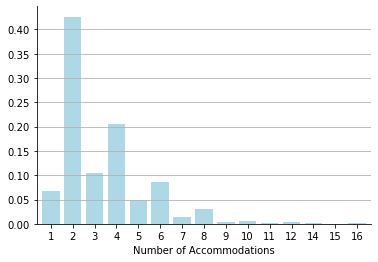

In [4]:
#Now looking to the number of accommodations
#For this question we just need the id and accommodates columns from the listing data
lst_accommodates = listings[['id','accommodates']].copy()
#Grouping by the data to get the counts of listings for each property_type
lst_accommodates_count = lst_accommodates.groupby(['accommodates']).count()
#Transforming the counts in percentage
lst_accommodates_count['perc'] = lst_accommodates_count['id'] / np.sum(lst_accommodates_count['id'])
lst_accommodates_count

#Create a bar plot to display the results
plot1 = lst_accommodates_count['perc'].plot(kind='bar',width=0.8,color='lightblue')
#Remove the top and right frame
plot1.spines['top'].set_visible(False)
plot1.spines['right'].set_visible(False)
#Rotate the x axis and insert label
plt.xticks(rotation=0)
plt.xlabel('Number of Accommodations')
#Insert grid in y axis
plt.grid(which='major', axis='y', linestyle='solid')
plt.show()

In [5]:
#Question 2: When is the best time of year to visit Seattle? What is the average price per day?
#For this question we need to aggregate the prices for weeks and see the price distribution throughout the year

#First step is converting the column 'date' of calendar dataFrame, and calculate the week
calendar_price = calendar.copy()
calendar_price['date'] = pd.to_datetime(calendar_price['date'], format='%Y-%m-%d')
calendar_price['week'] = calendar_price.apply(lambda x : x['date'].isocalendar()[1],axis=1)
print("Calendar table: \n {}".format(calendar_price.head()))

#To doesn't delete the rows with NaN price, we will fill them with their average value from the listings data
calendar_price = calendar_price.merge(listings[['id','price']], left_on='listing_id', right_on='id', how='left')
calendar_price = calendar_price.rename(columns={'price_x':'price','price_y':'average_price'})
print("Calendar with average price from listings table: \n {}".format(calendar_price.head()))
#Filling the NaN prices with the average price
calendar_price['price'].fillna(calendar_price['average_price'], inplace=True)
calendar_price = calendar_price[['id','date','week','available','price']]
#Convert the 'price' column from string to number, so we can do the aggregation
calendar_price = calendar_price.copy()
calendar_price['price'] = calendar_price['price'].replace('[\$,]', '', regex=True).astype(float)
print("Calendar with complete prices table: \n {}".format(calendar_price.head()))

Calendar table: 
    listing_id       date available   price  week
0      241032 2016-01-04         t  $85.00     1
1      241032 2016-01-05         t  $85.00     1
2      241032 2016-01-06         f     NaN     1
3      241032 2016-01-07         f     NaN     1
4      241032 2016-01-08         f     NaN     1
Calendar with average price from listings table: 
    listing_id       date available   price  week      id average_price
0      241032 2016-01-04         t  $85.00     1  241032        $85.00
1      241032 2016-01-05         t  $85.00     1  241032        $85.00
2      241032 2016-01-06         f     NaN     1  241032        $85.00
3      241032 2016-01-07         f     NaN     1  241032        $85.00
4      241032 2016-01-08         f     NaN     1  241032        $85.00
Calendar with complete prices table: 
        id       date  week available  price
0  241032 2016-01-04     1         t   85.0
1  241032 2016-01-05     1         t   85.0
2  241032 2016-01-06     1         f   8

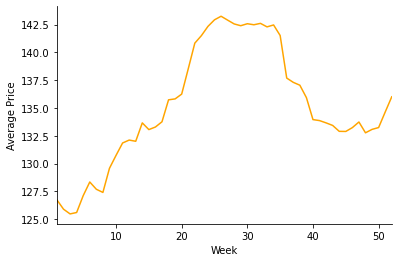

In [6]:
#Now that is all set, we just need to do the aggregation by week
mean_price_week = calendar_price.groupby(['week'])['price'].mean()

#Create a plot to better observe the mean prices obtained
plot2 = mean_price_week.plot(color='orange')
plot2.set_xlim(1, 52)
#Remove the top and right frame
plot2.spines['top'].set_visible(False)
plot2.spines['right'].set_visible(False)
#Defining the axis labels
plt.xlabel('Week')
plt.ylabel('Average Price')
plt.show()

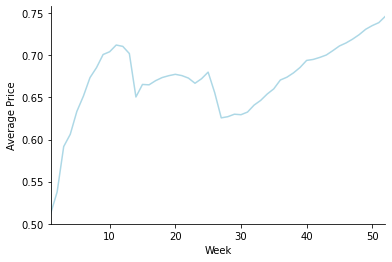

In [7]:
#Checking the availabity of listings
#First is necessary to count the listings available per day 
availability_day = calendar_price[calendar_price['available'] == 't'].groupby(['week','date'])['available'].count()
#Second we do a average of available listings per week and divide that by the total count of listings in Seattle
availability_week = availability_day.groupby(['week']).mean() / listings['id'].count()
availability_week

#Create a plot to better observe the mean prices obtained
plot2 = availability_week.plot(color='lightblue')
plot2.set_xlim(1, 52)
#Remove the top and right frame
plot2.spines['top'].set_visible(False)
plot2.spines['right'].set_visible(False)
#Defining the axis labels
plt.xlabel('Week')
plt.ylabel('Average Price')
plt.show()

In [8]:
#Question 3: What are the most expensive zones in Seattle? Does the higher priced locations have best scores?

#For this question we just need to look to the listings, neighbourhoods, prices and reviews
lst_location_reviews = listings[['id','price','neighbourhood_cleansed','review_scores_rating']].copy()
#In this case we can drop the NaN values
lst_location_reviews = lst_location_reviews.dropna()
#Convert the 'price' columns from string to number
lst_location_reviews = lst_location_reviews.copy()
lst_location_reviews['price'] = lst_location_reviews['price'].replace('[\$,]', '', regex=True).astype(float)

#Aggregate the neighbourhoods by prices and rates
lst_location_reviews_mean = lst_location_reviews.groupby(['neighbourhood_cleansed'])[['price','review_scores_rating']].mean()
lst_location_reviews_mean.describe()

,price,review_scores_rating
count,87.000000,87.000000
mean,122.370887,94.598621
std,35.986624,1.986258
min,62.933333,88.000000
25%,93.484594,93.807187
50%,117.250000,95.133333
75%,138.430884,95.849414
max,242.571429,98.000000


In [9]:
#Now I will divide the data in 3 category from the mean and standard deviation
def categorize(df,column_name):
    mean_value = df[column_name].mean()
    std_value = df[column_name].std()
    new_column_name = column_name + '_category'
    for i,value in df[column_name].items():
        if value < mean_value -  std_value :
            category = 1
        elif mean_value -  std_value <= value < mean_value + std_value:
            category = 2
        else:
            category = 3
        df.loc[i,new_column_name] = category
        

#We want to categorize the 2 columns
categorize(lst_location_reviews_mean,'price')
categorize(lst_location_reviews_mean,'review_scores_rating')

#Save the results into a csv to analysi in QGis
lst_location_reviews_mean.to_csv(r'neighbourhood_price_reviews_average.csv')